- This notebook is original fork from [Convert to Regression](https://www.kaggle.com/braquino/convert-to-regression), thanks to Bruno Aquino. 
- The idea of sampling is from discusion.
- The idea of "use agg stat feature of prediction" is from [qchemdog's solusion in Kaggle home credit default risk competition](https://github.com/NoxMoon/home-credit-default-risk)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot
# import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import json
pd.set_option('display.max_columns', 1000)

/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv


# Objective

* In the last notebook we create our baseline model including a feature selection part. 
* Cohen cappa score of 0.456 (lb) with a local cv score of 0.529
* In this notebook we are going to add more features and remove others that i think they overfitt the train set and then check if our local cv score improve.
* Next, we will check if this improvement aligns with the lb.

# Notes
* Check the distribution of the target variable of the out of folds score and the prediction distribution. A good model should more or less have the same distribution.

In [2]:
Id = "installation_id"
target = "accuracy_group"

In [3]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
#     reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [4]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [5]:
# input_path = "../input/"
input_path = "/kaggle/input/data-science-bowl-2019/"

def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv(input_path + 'train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv(input_path + 'test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv(input_path + 'train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv(input_path + 'specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv(input_path + 'sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [6]:
# read data
train, test, train_labels, specs, sample_submission = read_data()

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


In [7]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = sorted(list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique())))
    
    train['type_world'] = list(map(lambda x, y: str(x) + '_' + str(y), train['type'], train['world']))
    test['type_world'] = list(map(lambda x, y: str(x) + '_' + str(y), test['type'], test['world']))
    all_type_world = sorted(list(set(train["type_world"].unique()).union(test["type_world"].unique())))
    
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = sorted(list(set(train['title'].unique()).union(set(test['title'].unique()))))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = sorted(list(set(train['event_code'].unique()).union(set(test['event_code'].unique()))))
    list_of_event_id = sorted(list(set(train['event_id'].unique()).union(set(test['event_id'].unique()))))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = sorted(list(set(train['world'].unique()).union(set(test['world'].unique()))))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = sorted(list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index))))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code, activities_map,all_type_world

In [8]:
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code, activities_map,all_type_world = encode_title(train, test, train_labels)


#### save to pickle and reload

In [9]:
def cnt_miss(df):
    cnt = 0
    for e in range(len(df)):
        x = df['event_data'].iloc[e]
        y = json.loads(x)['misses']
        cnt += y
    return cnt

def get_4020_acc(df,counter_dict):
    
    for e in ['Cauldron Filler (Assessment)','Bird Measurer (Assessment)','Mushroom Sorter (Assessment)','Chest Sorter (Assessment)']:
        
        Assess_4020 = df[(df.event_code == 4020) & (df.title==activities_map[e])]   
        true_attempts_ = Assess_4020['event_data'].str.contains('true').sum()
        false_attempts_ = Assess_4020['event_data'].str.contains('false').sum()

        measure_assess_accuracy_ = true_attempts_/(true_attempts_+false_attempts_) if (true_attempts_+false_attempts_) != 0 else 0
        counter_dict[e+"_4020_accuracy"] += (counter_dict[e+"_4020_accuracy"] + measure_assess_accuracy_) / 2.0
    
    return counter_dict


In [10]:
# tag = "encode_title"

# # train
# result_path = "../temp/train_" + tag + ".pkl"
# train.to_pickle(result_path)

# # test
# result_path = "../temp/test_" + tag + ".pkl"
# test.to_pickle(result_path)

In [11]:
# tag = "encode_title"
# train = pd.read_pickle("../temp/train_" + tag + ".pkl")
# test = pd.read_pickle("../temp/test_" + tag + ".pkl")

# print('Reading sample_submission.csv file....')
# sample_submission = pd.read_csv(input_path + 'sample_submission.csv')
# print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))


In [12]:
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    assess_4020_acc_dict = {'Cauldron Filler (Assessment)_4020_accuracy':0,
                                'Mushroom Sorter (Assessment)_4020_accuracy':0,
                                'Bird Measurer (Assessment)_4020_accuracy':0,
                                'Chest Sorter (Assessment)_4020_accuracy':0 }
    
    game_time_dict = {'Clip_gametime':0, 'Game_gametime':0, 'Activity_gametime':0, 'Assessment_gametime':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    
    # Newly added features
    accumulated_game_miss = 0
    Cauldron_Filler_4025 = 0
    mean_game_round = 0
    mean_game_duration = 0 
    mean_game_level = 0
    Assessment_mean_event_count = 0
    Game_mean_event_count = 0
    Activity_mean_event_count = 0
    chest_assessment_uncorrect_sum = 0
    
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
    type_world_count: Dict[str, int] = {w_eve: 0 for w_eve in all_type_world}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
        if session_type=="Activity":
            Activity_mean_event_count = (Activity_mean_event_count + session['event_count'].iloc[-1])/2.0
            
        if session_type=="Game":
            
            Game_mean_event_count = (Game_mean_event_count + session['event_count'].iloc[-1])/2.0
            
            game_s = session[session.event_code == 2030]   
            misses_cnt = cnt_miss(game_s)
            accumulated_game_miss += misses_cnt
            
            try:
                game_round = json.loads(session['event_data'].iloc[-1])["round"]
                mean_game_round =  (mean_game_round + game_round)/2.0
            except:
                pass

            try:
                game_duration = json.loads(session['event_data'].iloc[-1])["duration"]
                mean_game_duration = (mean_game_duration + game_duration) /2.0
            except:
                pass
            
            try:
                game_level = json.loads(session['event_data'].iloc[-1])["level"]
                mean_game_level = (mean_game_level + game_level) /2.0
            except:
                pass
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(game_time_dict.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features.update(assess_4020_acc_dict.copy())
            features.update(type_world_count.copy())
            
            features['installation_session_count'] = sessions_count
            features['accumulated_game_miss'] = accumulated_game_miss
            features['mean_game_round'] = mean_game_round
            features['mean_game_duration'] = mean_game_duration
            features['mean_game_level'] = mean_game_level
            features['Assessment_mean_event_count'] = Assessment_mean_event_count
            features['Game_mean_event_count'] = Game_mean_event_count
            features['Activity_mean_event_count'] = Activity_mean_event_count
            features['chest_assessment_uncorrect_sum'] = chest_assessment_uncorrect_sum
            
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count),
                                ('var_type_world', type_world_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            
            features['Cauldron_Filler_4025'] = Cauldron_Filler_4025/counter if counter > 0 else 0
            ####################
            Assess_4025 = session[(session.event_code == 4025) & (session.title=='Cauldron Filler (Assessment)')]   
            true_attempts_ = Assess_4025['event_data'].str.contains('true').sum()
            false_attempts_ = Assess_4025['event_data'].str.contains('false').sum()

            cau_assess_accuracy_ = true_attempts_/(true_attempts_+false_attempts_) if (true_attempts_+false_attempts_) != 0 else 0
            Cauldron_Filler_4025 += cau_assess_accuracy_
            
            chest_assessment_uncorrect_sum += len(session[session.event_id=="df4fe8b6"])
            
            Assessment_mean_event_count = (Assessment_mean_event_count + session['event_count'].iloc[-1])/2.0
            ##############################
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # end session_type=="Assessment"
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')
        type_world_count = update_counters(type_world_count, 'type_world')
        
        assess_4020_acc_dict = get_4020_acc(session , assess_4020_acc_dict)
        game_time_dict[session_type+'_gametime'] = (game_time_dict[session_type+'_gametime'] + (session['game_time'].iloc[-1]/1000.0))/2.0
        
        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [13]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    
    compiled_test_his = []
    for i, (ins_id, user_sample) in tqdm(enumerate(test.groupby('installation_id', sort = False)), total = 1000):
        compiled_test_his += get_data(user_sample)
    reduce_test_his = pd.DataFrame(compiled_test_his)
    
    return reduce_train, reduce_test, categoricals, reduce_test_his

In [14]:
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals, reduce_test_his = get_train_and_test(train, test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [15]:
reduce_train.shape, reduce_test.shape, reduce_test_his.shape

((17690, 932), (1000, 932), (2018, 932))

In [16]:
reduce_train.head()

,Clip,Activity,Assessment,Game,acc_Bird Measurer (Assessment),acc_Cart Balancer (Assessment),acc_Cauldron Filler (Assessment),acc_Chest Sorter (Assessment),acc_Mushroom Sorter (Assessment),2000,2010,2020,2025,2030,2035,2040,2050,2060,2070,2075,2080,2081,2083,3010,3020,3021,3110,3120,3121,4010,4020,4021,4022,4025,4030,4031,4035,4040,4045,4050,4070,4080,4090,4095,4100,4110,4220,4230,4235,5000,5010,003cd2ee,0086365d,00c73085,01ca3a3c,022b4259,02a42007,0330ab6a,0413e89d,04df9b66,05ad839b,06372577,070a5291,08fd73f3,08ff79ad,0a08139c,0ce40006,0d18d96c,0d1da71f,0db6d71d,119b5b02,1325467d,1340b8d7,1375ccb7,13f56524,14de4c5d,155f62a4,1575e76c,15a43e5b,15ba1109,15eb4a7d,15f99afc,160654fd,16667cc5,16dffff1,17113b36,17ca3959,19967db1,1996c610,1af8be29,1b54d27f,1bb5fbdb,1beb320a,1c178d24,1cc7cfca,1cf54632,1f19558b,222660ff,2230fab4,250513af,25fa8af4,262136f4,26a5a3dd,26fd2d99,27253bdc,28520915,28a4eb9a,28ed704e,28f975ea,29a42aea,29bdd9ba,29f54413,2a444e03,2a512369,2b058fe3,2b9272f4,2c4e6db0,2dc29e21,2dcad279,2ec694de,2fb91ec1,30614231,30df3273,31973d56,3323d7e9,33505eae,3393b68b,363c86c9,363d3849,36fa3ebe,37937459,37c53127,37db1c2f,37ee8496,38074c54,392e14df,3a4be871,3afb49e6,3afde5dd,3b2048ee,3babcb9b,3bb91ced,3bb91dda,3bf1cf26,3bfd1a65,3ccd3f02,3d0b9317,3d63345e,3d8c61b0,3dcdda7f,3ddc79c3,3dfd4aa4,3edf6747,3ee399c3,4074bac2,44cb4907,45d01abe,461eace6,46b50ba8,46cd75b4,47026d5f,47efca07,47f43a44,48349b14,4901243f,499edb7c,49ed92e9,4a09ace1,4a4c3d21,4b5efe37,4bb2f698,4c2ec19f,4d6737eb,4d911100,4e5fc6f5,4ef8cdd3,51102b85,51311d7a,5154fc30,5290eab1,532a2afb,5348fd84,53c6e11a,55115cbd,562cec5f,565a3990,56817e2b,56bcd38d,56cd3b43,5859dfb6,587b5989,58a0de5c,598f4598,5a848010,5b49460a,5be391b5,5c2f29ca,5c3d2b2f,5d042115,5dc079d8,5de79a6a,5e109ec3,5e3ea25a,5e812b27,5f0eb72c,5f5b2617,6043a2b4,6077cc36,6088b756,611485c5,63f13dd7,65a38bf7,65abac75,67439901,67aa2ada,69fdac0a,6aeafed4,6bf9e3e1,6c517a88,6c930e6e,6cf7d25c,6d90d394,6f445b57,6f4adc4b,6f4bd64e,6f8106d9,7040c096,709b1251,71e712d8,71fe8f75,731c0cbe,736f9581,7372e1a5,73757a5e,7423acbc,74e5f8a7,7525289a,756e5507,763fc34e,76babcde,77261ab5,77c76bc5,77ead60d,792530f8,795e4a37,7961e599,7ab78247,7ad3efc6,7cf1bc53,7d093bf9,7d5c30a2,7da34a02,7dfe6d8a,7ec0c298,7f0836bf,7fd1ac25,804ee27f,828e68f9,832735e1,83c6c409,84538528,84b0e0c8,857f21c0,85d1b0de,85de926c,86ba578b,86c924c4,87d743c1,884228c8,88d4a5be,895865f3,89aace00,8ac7cce4,8af75982,8b757ab8,8d748b58,8d7e386c,8d84fa81,8f094001,8fee50e2,907a054b,90d848e0,90ea0bac,90efca10,91561152,923afab1,92687c59,93b353f2,93edfe2e,9554a50b,99abe2bb,99ea62f3,9b01374f,9b23e8ee,9b4001e4,9c5ef70c,9ce586dd,9d29771f,9d4e7b25,9de5e594,9e34ea74,9e4c8c7b,9e6b7fb5,9ed8f6da,9ee1c98c,a0faea5d,a1192f43,a16a373e,a1bbe385,a1e4395d,a29c5338,a2df0760,a44b10dc,a52b92d5,a592d54e,a5be6304,a5e9da97,a6d66e51,a76029ee,a7640a16,a8876db3,a8a78786,a8cc6fec,a8efe47b,ab3136ba,ab4ec3a4,abc5811c,ac92046e,acf5c23f,ad148f58,ad2fc29c,b012cd7f,b120f2ac,b1d5101d,b2dba42b,b2e5b0f1,b5053438,b74258a0,b7530680,b7dc8128,b80e5e84,b88f38da,bb3e370b,bbfe0445,bc8f2793,bcceccc6,bd612267,bd701df8,bdf49a58,beb0a7b9,bfc77bd6,c0415e5c,c189aaf2,c1cac9a2,c277e121,c2baf0bd,c51d8688,c54cf6c5,c58186bf,c6971acf,c7128948,c74f40cd,c7f7f0e1,c7fe2a55,c952eb01,ca11f653,cb1178ad,cb6010f8,cc5087a3,cdd22e43,cf7638f3,cf82af56,cfbd47c8,d02b7a8e,d06f75b5,d122731b,d185d3ea,d2278a3b,d2659ab4,d2e9262e,d3268efa,d3640339,d38c2fd7,d3f1e122,d45ed6a1,d51b1749,d88ca108,d88e8f25,d9c005dd,daac11b0,db02c830,dcaede90,dcb1663e,dcb55a27,de26c3a6,df4940d3,df4fe8b6,e04fb33d,e080a381,e37a2b78,e3ff61fb,e4d32835,e4f1efe6,e5734469,e57dd7af,e5c9df6f,e64e2cfd,e694a35b,e720d930,e7561dd2,e79f3763,e7e44842,e9c52111,ea296733,ea321fb1,eb2c19cd,ec138c1c,ecaab346,ecc36b7f,ecc6157f,f28c589a,f32856e4,f3cd5473,f50fc6c1,f54238ee,f56e0afc,f5b8c21a,f6947f54,f71c4741,f7e47413,f806dc10,f93fc684,fbaf3456,fcfdffb6,fd20ea40,12 Monkeys,Air Show,All Star Sorting,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart B

In [17]:
categoricals = ['session_title']

In [18]:
def run_lgb_regression(reduce_train, reduce_test, usefull_features, n_splits, depth):
    kf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = 42)
    target = 'accuracy_group'
    oof_pred = np.zeros((len(reduce_train), ))
    y_pred = np.zeros((len(reduce_test), ))
    for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, reduce_train[target])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = reduce_train[usefull_features].iloc[tr_ind], reduce_train[usefull_features].iloc[val_ind]
        y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=categoricals)
        
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': depth,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'verbose': 100,
                    'early_stopping_rounds': 100
                    }
        
        model = lgb.train(params, train_set, num_boost_round = 1000000, early_stopping_rounds = 300, 
                          valid_sets=[train_set, val_set], verbose_eval = 100)
        oof_pred[val_ind] = model.predict(x_val)
        y_pred += model.predict(reduce_test[usefull_features]) / n_splits
    _, loss_score, _ = eval_qwk_lgb_regr(reduce_train[target], oof_pred)
    print('Our oof cohen kappa score is: ', loss_score)

    return y_pred, loss_score


In [19]:
def run_xgb_regression(reduce_train, reduce_test, usefull_features, n_splits):
    kf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = 42)
    target = 'accuracy_group'
    oof_pred = np.zeros((len(reduce_train), ))
    y_pred = np.zeros((len(reduce_test), ))
    for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, reduce_train[target])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = reduce_train[usefull_features].iloc[tr_ind], reduce_train[usefull_features].iloc[val_ind]
        y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
        xgb_train = xgb.DMatrix(x_train, y_train)
        xgb_eval = xgb.DMatrix(x_val, y_val)

        pars = {
            'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':5,
            'gamma':0.25,
            'n_estimators':5000
        }

        model = xgb.train(pars,
                      xgb_train,
                      num_boost_round=5000,
                      evals=[(xgb_train, 'train'), (xgb_eval, 'val')],
                      verbose_eval=100,
                      early_stopping_rounds=100
                     )
        
        val_X=xgb.DMatrix(x_val)
        oof_pred[val_ind] = model.predict(val_X)
        test_X = xgb.DMatrix(reduce_test[usefull_features])
        y_pred += model.predict(test_X) / n_splits
    _, loss_score, _ = eval_qwk_lgb_regr(reduce_train[target], oof_pred)
    print('Our oof cohen kappa score is: ', loss_score)

    return y_pred


In [20]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [21]:
to_exclude = []
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

acc_Cart Balancer (Assessment) -0.04020325710970116 -0.47065833333333346
003cd2ee 0.0 0.0
01ca3a3c 0.0004522328999434709 0.0
0ce40006 0.0008479366873940079 0.0
119b5b02 0.0002826455624646693 0.0
13f56524 0.04392312040700961 0.0
17ca3959 0.0 0.0
1b54d27f 0.0007348784624081402 0.0
29a42aea 0.004070096099491238 0.0
2ec694de 0.008988128886376484 0.0
4074bac2 0.0 0.0
5dc079d8 0.0 0.0
611485c5 0.0013566986998304127 0.0
6aeafed4 0.14703222159412097 0.008
7fd1ac25 0.01978518937252685 0.0
a8cc6fec 0.0 0.0
ab4ec3a4 0.0009044657998869418 0.0
bfc77bd6 0.012832108535895986 0.0
dcb1663e 0.0 0.0
e4d32835 0.0013001695873374789 0.0
eb2c19cd 0.17382702091577162 0.008
ecc6157f 0.007292255511588468 0.0
Clip_gametime 0.0 0.0
Air Show_4080 0.0 0.0
Bottle Filler (Activity)_2010 0.0 0.0
Bubble Bath_4080 0.004070096099491238 0.0
Bubble Bath_4090 0.14703222159412097 0.008
Bug Measurer (Activity)_4080 0.008988128886376484 0.0
Cart Balancer (Assessment)_4080 0.007292255511588468 0.0
Chest Sorter (Assessment)_4080

In [22]:
features = [x for x in features if x not in to_exclude]
reduce_train[features].shape

(17690, 881)

In [23]:
reduce_train_origin = reduce_train.copy()

### use groupby-agg stat of prediction as features

In [24]:
## sample
his_idx = []

used_idx = []
from tqdm import tqdm_notebook, tqdm
import random
random.seed(1260)
for iid in tqdm_notebook(set(reduce_train_origin[Id])):
    list_ = list(reduce_train_origin.loc[reduce_train_origin[Id] == iid].index)
#     print(list_)
    
    cur = random.choices(list_, k=1)[0]
    cur_target = reduce_train_origin.loc[cur, target]
    his = [x for x in list_ if x < cur]
    his_idx.append([his, cur_target])
    
    used_idx.append(cur)
print(len(used_idx))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



3614


In [25]:
train_feature = pd.DataFrame()
for i in tqdm_notebook(range(len(his_idx))):
    temp_feature = reduce_train_origin.loc[his_idx[i][0]]
    temp_feature["feature_target"] = his_idx[i][1]
    train_feature = train_feature.append(temp_feature)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [26]:
test_feature = reduce_test_his.copy()
test_feature["feature_target"] = -1

In [27]:
train_feature.shape, test_feature.shape

((7114, 933), (2018, 933))

In [28]:
train_x = train_feature[features]
train_y = train_feature[target]
test_x  = test_feature[features]

In [29]:
# debug for "LightGBMError: Do not support special JSON characters in feature name."
features = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features]
train_x.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in train_x.columns]
test_x.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test_x.columns]

reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
reduce_test.columns  = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_test.columns]
ajusted_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in ajusted_test.columns]

In [30]:
# Run a 5 fold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
oof_preds = np.zeros(train_x.shape[0])
sub_preds = np.zeros(test_x.shape[0])

In [31]:
category = ['session_title']

lr = 0.1
Early_Stopping_Rounds = 150

N_round = 5000
Verbose_eval = 100

params =  {'num_leaves': 61,  # 当前base 61
           'min_child_weight': 0.03454472573214212,
           'feature_fraction': 0.3797454081646243,
           'bagging_fraction': 0.4181193142567742,
           'min_data_in_leaf': 96,  # 当前base 106
           'objective': 'regression',
           "metric": 'rmse',
           'max_depth': -1,
           'learning_rate': lr,   # 快速验证
    #      'learning_rate': 0.006883242363721497,
           "boosting_type": "gbdt",
           "bagging_seed": 11,
           "verbosity": -1,
           'reg_alpha': 0.3899927210061127,
           'reg_lambda': 0.6485237330340494,
           'random_state': 47,
           'num_threads': 16,
           'lambda_l1': 1,  
           'lambda_l2': 1
    #      'is_unbalance':True
             }

In [32]:
import datetime
from sklearn.metrics import mean_squared_error

oof_preds = np.zeros(train_x.shape[0])
sub_preds = np.zeros(test_x.shape[0])

feature_importances = pd.DataFrame()
feature_importances['feature'] = train_x[features].columns

RMSEs = []

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_x, train_y)):
    
    start_time = time()
    print('Training on fold {}'.format(n_fold + 1))
    
    trn_data = lgb.Dataset(train_x[features].iloc[trn_idx], label=train_y.iloc[trn_idx],
                           categorical_feature=category)
    val_data = lgb.Dataset(train_x[features].iloc[val_idx], label=train_y.iloc[val_idx],
                           categorical_feature=category)

    clf = lgb.train(params, trn_data, num_boost_round=N_round, valid_sets=[trn_data, val_data],
                    verbose_eval=Verbose_eval, early_stopping_rounds=Early_Stopping_Rounds)
    
    val = clf.predict(train_x[features].iloc[val_idx])
    oof_preds[val_idx] = val
    
    sub_preds += clf.predict(test_x[features]) / folds.n_splits
    
    rmse = np.sqrt(mean_squared_error(train_y.iloc[val_idx], val))
    print('RMSE: {}'.format(rmse))
    RMSEs.append(rmse)
    
    feature_importances['fold_{}'.format(n_fold + 1)] = clf.feature_importance()
    
    print('fold {} finished in {}'.format(n_fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

Training on fold 1


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.702539	valid_1's rmse: 1.01355
[200]	training's rmse: 0.556697	valid_1's rmse: 1.02616
Early stopping, best iteration is:
[59]	training's rmse: 0.79904	valid_1's rmse: 1.00785
RMSE: 1.007847912624574
fold 1 finished in 0:00:12.538217
Training on fold 2


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.703903	valid_1's rmse: 1.03068
[200]	training's rmse: 0.556015	valid_1's rmse: 1.0375
Early stopping, best iteration is:
[62]	training's rmse: 0.789688	valid_1's rmse: 1.02553
RMSE: 1.0255325145106118
fold 2 finished in 0:00:11.514221
Training on fold 3


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.704866	valid_1's rmse: 1.02011
[200]	training's rmse: 0.556096	valid_1's rmse: 1.03649
Early stopping, best iteration is:
[67]	training's rmse: 0.778475	valid_1's rmse: 1.01003
RMSE: 1.0100286566199532
fold 3 finished in 0:00:11.648572
Training on fold 4


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.700048	valid_1's rmse: 1.02661
[200]	training's rmse: 0.553925	valid_1's rmse: 1.03261
Early stopping, best iteration is:
[116]	training's rmse: 0.669155	valid_1's rmse: 1.02507
RMSE: 1.0250680723986723
fold 4 finished in 0:00:14.022262
Training on fold 5


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.701329	valid_1's rmse: 1.02479
[200]	training's rmse: 0.556517	valid_1's rmse: 1.0422
Early stopping, best iteration is:
[55]	training's rmse: 0.808777	valid_1's rmse: 1.01934
RMSE: 1.01934171876164
fold 5 finished in 0:00:11.253222


In [33]:
print(RMSEs)
print('Mean RMSE:', np.mean(RMSEs))

[1.007847912624574, 1.0255325145106118, 1.0100286566199532, 1.0250680723986723, 1.01934171876164]
Mean RMSE: 1.0175637749830904


In [34]:
feature_importances['average'] = feature_importances[[x for x in feature_importances.columns if x != "feature"]].mean(axis=1)
feature_importances = feature_importances.sort_values(by = "average", ascending = False)
feature_importances

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,average
858,mean_game_duration,48,57,52,70,43,54.0
862,Activity_mean_event_count,44,43,43,92,40,52.4
39,4070,45,53,54,63,31,49.2
869,session_title,44,40,42,75,42,48.6
857,mean_game_round,39,38,49,80,30,47.2
...,...,...,...,...,...,...,...
244,83c6c409,0,0,0,0,0,0.0
762,Mushroom_Sorter__Assessment__2025,0,0,0,0,0,0.0
759,Mushroom_Sorter__Assessment__2000,0,0,0,0,0,0.0
593,Cauldron_Filler__Assessment__4090,0,0,0,0,0,0.0


In [35]:
train_feature_score = train_feature[[Id]]
train_feature_score['score'] = oof_preds
test_feature_score = test_feature[[Id]]
test_feature_score['score'] = sub_preds

feature_score = pd.concat([train_feature_score, test_feature_score])
# feature_score.to_csv('../temp/feature_score.csv',index=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [36]:
# groupby之后的预测值作为特征
feature_agg = feature_score.groupby(Id).agg({'score': ['mean', 'sum', 'max', 'var']}).reset_index()
feature_agg.columns = [Id, 'score_mean', 'score_sum', 'score_max', 'score_var']

In [37]:
feature_agg.head()

,installation_id,score_mean,score_sum,score_max,score_var
0,0006a69f,1.906942,7.627767,1.957610,0.001436
1,002db7e3,1.788504,7.154017,2.807027,0.934084
2,004c2091,1.418461,4.255382,1.627931,0.063773
3,00691033,1.082076,3.246228,1.305130,0.048551
4,00a0dbeb,2.158864,2.158864,2.158864,NaN


In [38]:
# 按Id和上面生成的特征merge
reduce_train = pd.merge(reduce_train, feature_agg, on = Id, how = "left")
reduce_test = pd.merge(reduce_test, feature_agg, on = Id, how = "left")
ajusted_test = pd.merge(ajusted_test, feature_agg, on = Id, how = "left")

In [39]:
# use reduce_train as training data

In [40]:
reduce_train.shape, reduce_test.shape

((17690, 936), (1000, 936))

In [41]:
reduce_train = reduce_train.loc[used_idx]
reduce_train.index = range(len(reduce_train))

In [42]:
reduce_train.shape, reduce_test.shape, ajusted_test.shape

((3614, 936), (1000, 936), (1000, 936))

### run model

In [43]:
"score_mean" in features

False

In [44]:
features.extend(['score_mean', 'score_sum', 'score_max', 'score_var'])

In [45]:
reduce_train.shape

(3614, 936)

In [46]:
depth = 15
# y_lgb_pred, loss_score = run_lgb_regression(train_app, ajusted_test, features, 5, depth)
y_lgb_pred, loss_score = run_lgb_regression(reduce_train, ajusted_test, features, 5, depth)

Fold 1


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.02554	valid_1's rmse: 1.10224
[200]	training's rmse: 0.91155	valid_1's rmse: 1.06111
[300]	training's rmse: 0.839809	valid_1's rmse: 1.05264
[400]	training's rmse: 0.784834	valid_1's rmse: 1.0511
[500]	training's rmse: 0.737728	valid_1's rmse: 1.05175
Early stopping, best iteration is:
[458]	training's rmse: 0.756702	valid_1's rmse: 1.05001
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.0257	valid_1's rmse: 1.10767
[200]	training's rmse: 0.911992	valid_1's rmse: 1.07525
[300]	training's rmse: 0.841293	valid_1's rmse: 1.06972
[400]	training's rmse: 0.785321	valid_1's rmse: 1.06984
Early stopping, best iteration is:
[366]	training's rmse: 0.803433	valid_1's rmse: 1.06873
Fold 3
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01951	valid_1's rmse: 1.12522
[200]	training's rmse: 0.906437	valid_1's rmse: 1.0952
[300]	tra

In [47]:
final_pred = y_lgb_pred

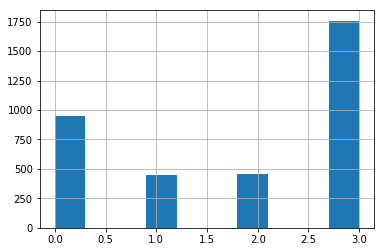

In [48]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

In [49]:
acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('./submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)

{0: 1.383665169876203, 1: 1.6819090145138007, 2: 1.916323812103363}


3    0.486
0    0.263
1    0.126
2    0.125
Name: accuracy_group, dtype: float64